# GitHub Advisories Analysis

## Setup and data loading

### Import dependencies

In [1]:
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
%config InlineBackend.figure_format = "retina"

### Load advisories and affected packages from sqlite

In [2]:
conn = sqlite3.connect("data/advisory-database.db")

In [3]:
advisories = pd.read_sql_query(
    "SELECT ghsa, published, modified, cve, severity, cwes FROM advisories",
    conn,
    parse_dates=["published", "modified"],
)
advisories.cwes = advisories.cwes.apply(lambda v: frozenset(json.loads(v)))
print(advisories.shape[0], 'rows')
advisories.head()

187145 rows


,ghsa,published,modified,cve,severity,cwes
0,GHSA-m65r-8cxg-p9wc,2022-05-24 19:07:41+00:00,2022-05-24 19:07:41+00:00,CVE-2021-34300,HIGH,"(CWE-20, CWE-787)"
1,GHSA-rr77-8xvw-xxm9,2022-05-13 01:44:38+00:00,2022-05-13 01:44:38+00:00,CVE-2017-18246,MODERATE,(CWE-125)
2,GHSA-2mp5-w5jx-qmrm,2022-05-17 01:46:31+00:00,2022-05-17 01:46:31+00:00,CVE-2012-2205,LOW,(CWE-79)
3,GHSA-mwq4-948j-88c5,2022-05-14 00:55:59+00:00,2022-05-14 00:55:59+00:00,CVE-2018-8779,HIGH,(CWE-20)
4,GHSA-4282-645v-4hqh,2022-05-14 02:22:42+00:00,2022-05-14 02:22:42+00:00,CVE-2016-7205,HIGH,(CWE-119)


In [4]:
packages = pd.read_sql_query("SELECT ghsa, name AS package, ecosystem FROM affected_packages", conn)
print(packages.shape[0], 'rows')
packages.head()

16568 rows


,ghsa,package,ecosystem
0,GHSA-8p5q-j9m2-g8wr,lodash,npm
1,GHSA-r9cr-hvjj-496v,github.com/argoproj/argo-cd,Go
2,GHSA-r9cr-hvjj-496v,github.com/argoproj/argo-cd,Go
3,GHSA-r9cr-hvjj-496v,github.com/argoproj/argo-cd,Go
4,GHSA-2j6v-xpf3-xvrv,com.wire:avs,Maven


In [5]:
conn.close()

### Load CWE definitions from MITRE CSVs

In [6]:
cwes = pd.concat([pd.read_csv("data/cwes/699.csv"), pd.read_csv("data/cwes/1000.csv"), pd.read_csv("data/cwes/1194.csv")]).drop_duplicates()
cwes = cwes[['CWE-ID']].rename(columns={'CWE-ID': 'cwe_name'}).reset_index(names='cwe_id')
cwes.cwe_id = cwes.cwe_id.apply(lambda i: f"CWE-{i:d}")
cwes.head()

,cwe_id,cwe_name
0,CWE-15,External Control of System or Configuration Se...
1,CWE-23,Relative Path Traversal
2,CWE-36,Absolute Path Traversal
3,CWE-41,Improper Resolution of Path Equivalence
4,CWE-59,Improper Link Resolution Before File Access ('...


## Advisory severity by ecosystem

In [7]:
package_vulns = pd.merge(packages, advisories, on="ghsa").drop_duplicates()
print(package_vulns.shape)
package_vulns.head()

(11092, 8)


,ghsa,package,ecosystem,published,modified,cve,severity,cwes
0,GHSA-8p5q-j9m2-g8wr,lodash,npm,2021-12-03 20:37:32+00:00,2021-12-02 00:01:18+00:00,CVE-2021-41720,LOW,(CWE-77)
1,GHSA-r9cr-hvjj-496v,github.com/argoproj/argo-cd,Go,2022-03-24 00:04:03+00:00,2022-03-24 00:04:03+00:00,CVE-2022-24730,HIGH,"(CWE-284, CWE-22)"
4,GHSA-2j6v-xpf3-xvrv,com.wire:avs,Maven,2022-03-01 18:58:23+00:00,2022-03-10 15:59:41+00:00,CVE-2021-41193,HIGH,(CWE-134)
5,GHSA-cr3q-pqgq-m8c2,swagger-ui,npm,2022-03-12 00:00:36+00:00,2022-03-29 19:09:55+00:00,CVE-2018-25031,MODERATE,(CWE-20)
6,GHSA-hf4q-52x6-4p57,microweber/microweber,Packagist,2022-03-11 00:02:36+00:00,2022-03-28 22:23:29+00:00,CVE-2022-0906,MODERATE,(CWE-79)


In [8]:
severity_order = ["LOW", "MODERATE", "HIGH", "CRITICAL"]
package_vulns.severity.value_counts().reindex(severity_order)

LOW          724
MODERATE    4332
HIGH        4239
CRITICAL    1797
Name: severity, dtype: int64

<AxesSubplot: xlabel='year'>

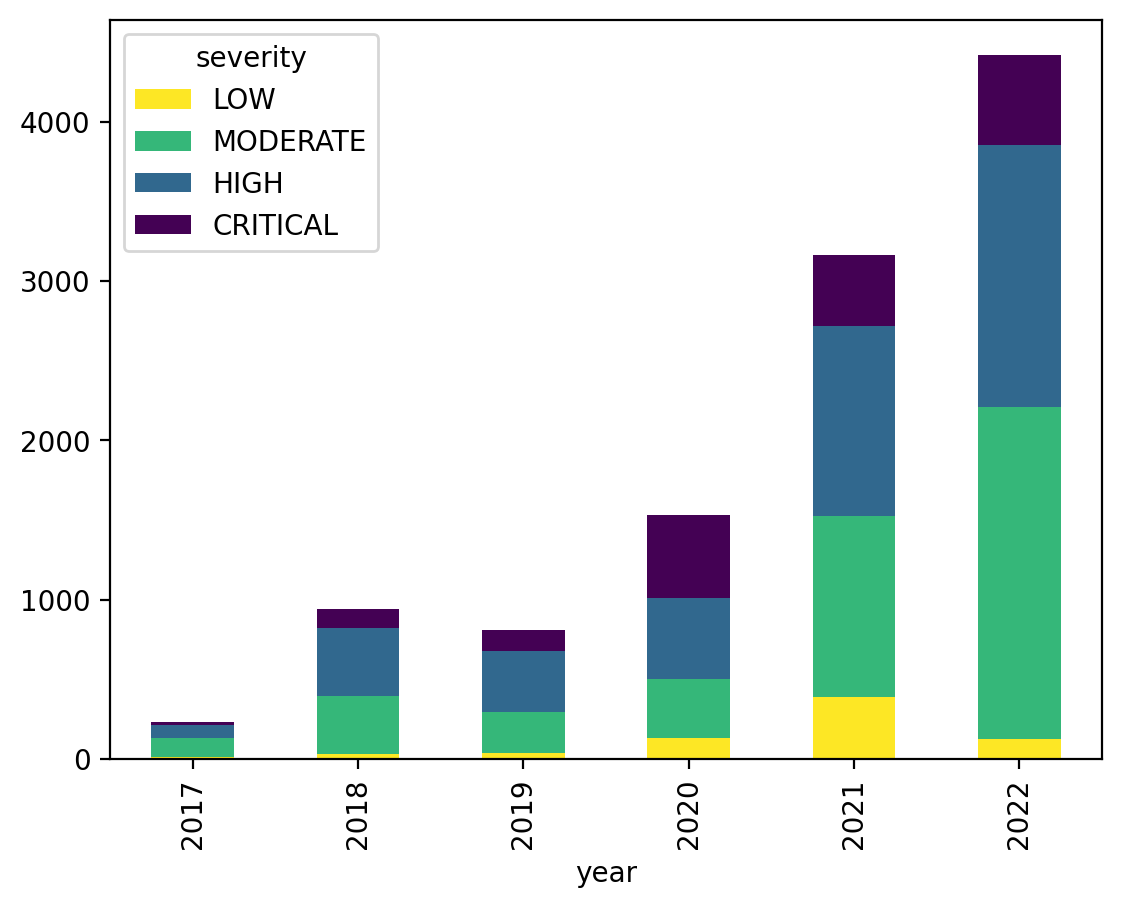

In [9]:
vulns_by_year = package_vulns.assign(year=package_vulns.published.dt.year).groupby("year")
color_map = matplotlib.colormaps['viridis'].reversed()
vulns_by_year.severity.value_counts().unstack()[severity_order].plot(kind="bar", stacked=True, colormap=color_map)

## Top CWEs by ecosystem

In [11]:
cwe_counts = package_vulns.explode('cwes').rename(columns={'cwes': 'cwe_id'}).groupby(['ecosystem', 'cwe_id'])['ghsa'].count().reset_index()
cwe_counts = cwe_counts.rename(columns={'ghsa': 'count'})
cwe_counts = cwe_counts.sort_values(['ecosystem', 'count'], ascending=False).groupby('ecosystem').head(5)
pd.merge(cwe_counts, cwes, on='cwe_id').sort_values(['ecosystem', 'count'], ascending=False)

,ecosystem,cwe_id,count,cwe_name
0,npm,CWE-506,379,Embedded Malicious Code
1,npm,CWE-79,364,Improper Neutralization of Input During Web Pa...
7,npm,CWE-22,241,Improper Limitation of a Pathname to a Restric...
10,npm,CWE-400,222,Uncontrolled Resource Consumption
13,npm,CWE-1321,194,Improperly Controlled Modification of Object P...
14,crates.io,CWE-362,75,Concurrent Execution using Shared Resource wit...
15,crates.io,CWE-416,45,Use After Free
16,crates.io,CWE-908,40,Use of Uninitialized Resource
17,crates.io,CWE-787,37,Out-of-bounds Write
20,crates.io,CWE-119,28,Improper Restriction of Operations within the ...
